## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Required Libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
%matplotlib inline 

## 1. Construct a function that can undistort images taken by the camera

In [2]:
def getCameraCalibrationParameters(calibration_images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img = None
    
    for fname in calibration_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            #Draw the corners and write image to file
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            head, tail = os.path.split(fname)
            write_name = './my_output/corners_found-'+tail[:-4]+'.jpg'
            cv2.imwrite(write_name,img)
    return objpoints,imgpoints,(img.shape[1],img.shape[0])

In [3]:
def makeUndistorter(objpoints,imgpoints,img_size):
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    def undistorter(img):
        return cv2.undistort(img,mtx,dist)
        
    return undistorter
    

In [4]:
# Make a list of calibration images
cal_images = glob.glob('./camera_cal/calibration*.jpg')

objpoints,imgpoints,cal_img_size = getCameraCalibrationParameters(cal_images)

# construct a function that can undistort images taken by the camera
undist = makeUndistorter(objpoints,imgpoints,cal_img_size)

## 2. Undistort a test chessboard image

In [5]:
# Test undistoring of the image
test_image_to_undistort = './camera_cal/calibration1.jpg'
img_undistored = undist(cv2.imread(test_image_to_undistort))
cv2.imwrite('./my_output/calibration1-undistorted.jpg',img_undistored)

True

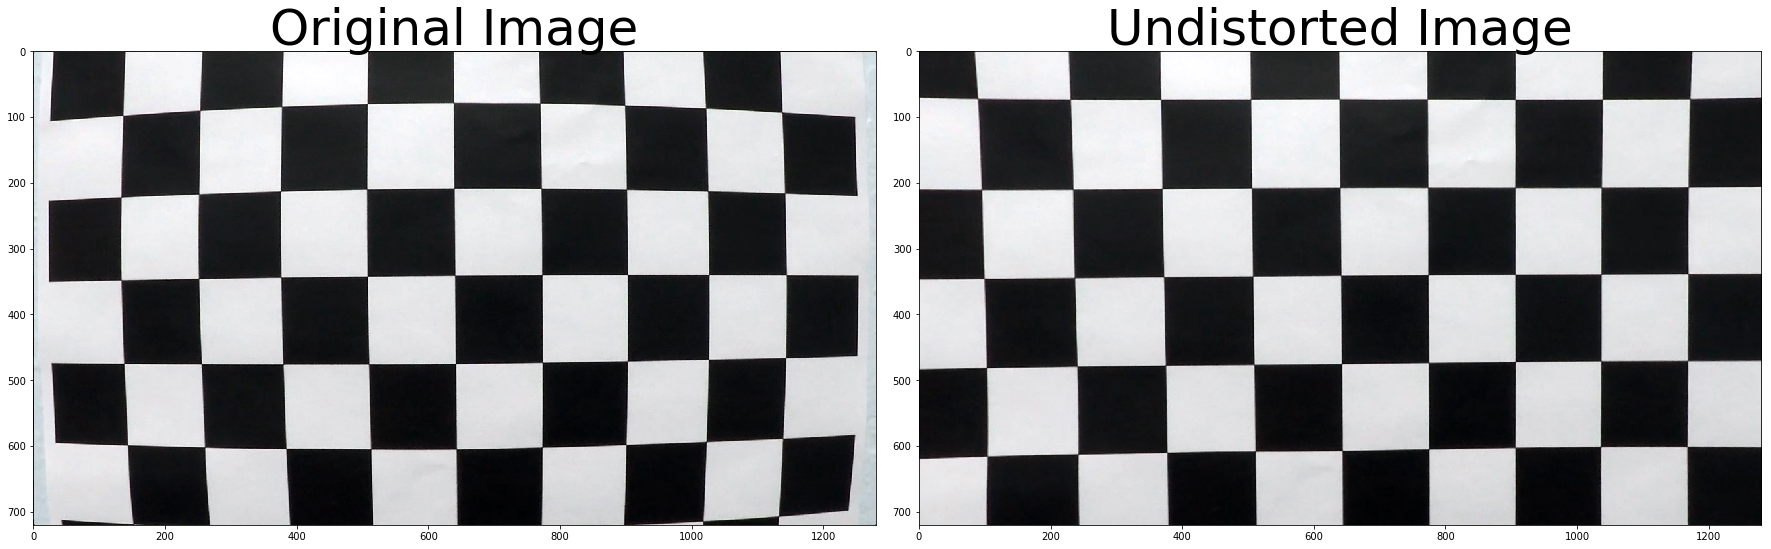

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.imread(test_image_to_undistort))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undistored)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Undistort the road images in the Test folder

In [7]:
test_road_image_filenames = glob.glob('./test_images/*.jpg')
test_road_images = list(map(lambda x: cv2.imread(x),test_road_image_filenames))
test_road_images_undistorted = list(map(lambda z: undist(z) ,map(lambda x: cv2.imread(x),test_road_image_filenames)))

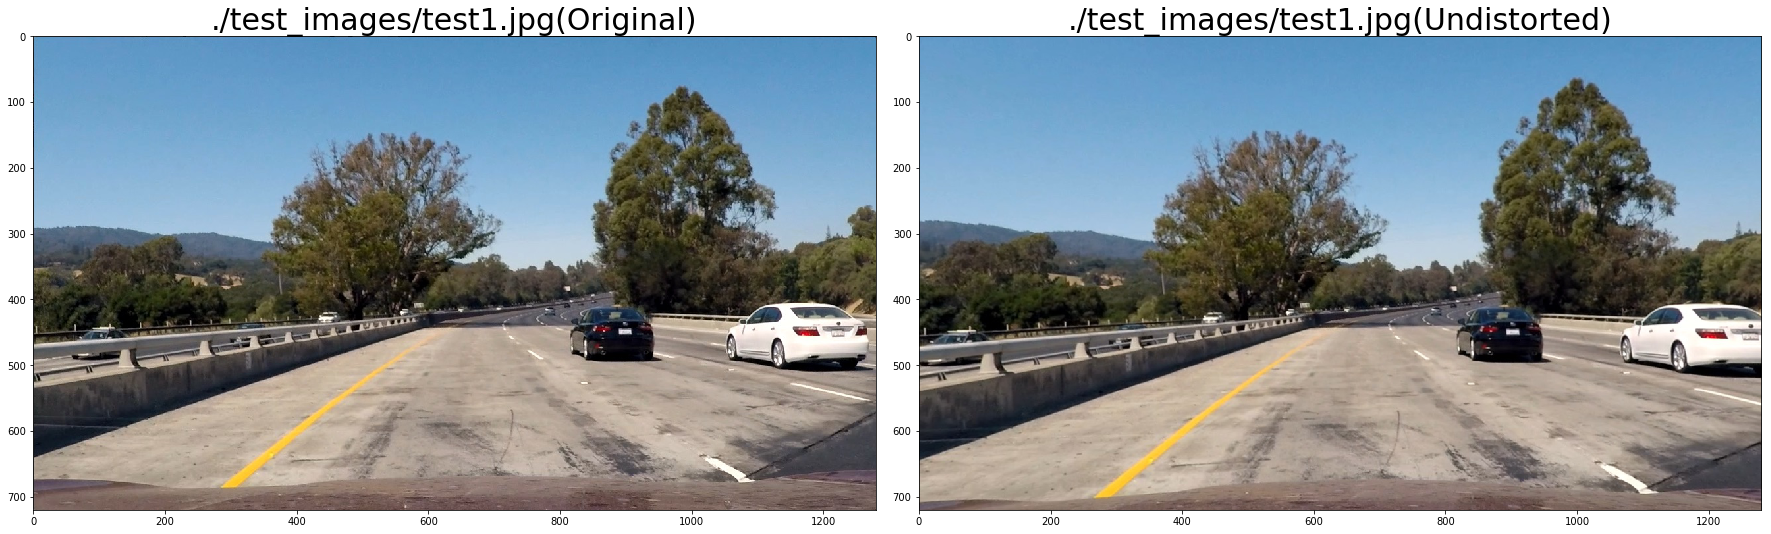

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(test_road_images[2], cv2.COLOR_BGR2RGB))
ax1.set_title(test_road_image_filenames[2]+'(Original)', fontsize=30)
ax2.imshow(cv2.cvtColor(test_road_images_undistorted[2], cv2.COLOR_BGR2RGB))
ax2.set_title(test_road_image_filenames[2]+'(Undistorted)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Create pipeline function to turn road images into binary

In [9]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [10]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)

    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(img, thresh=(0, np.pi/2)):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
   
    return s_binary

In [11]:
def pipeline(img, s_thresh=(150, 255), sx_thresh=(90, 200), sy_thresh=(90, 200),
             m_thresh=(84, 54),dir_thresh=(0.9, 0.6), ksize=3):
    
    image = np.copy(img)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # define range of yellow color in HSV
    lower_yellow = np.array([ 0, 80, 200])
    upper_yellow = np.array([ 40, 255, 255])
    
    # define range of white color in HSV
    lower_white = np.array([  0,   0,   180])
    upper_white = np.array([ 255,  25, 255])

    # Threshold the HSV image to get only yellow color
    mask1 = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # Threshold the HSV image to get only white color
    mask2 = cv2.inRange(hsv, lower_white, upper_white)
    
    # Combine the white and yellow masks
    mask = cv2.add(mask1,mask2)
    
    # apply the mask to the image
    res = cv2.bitwise_and(image,image, mask= mask)
    
    #plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(res, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    grady = abs_sobel_thresh(res, orient='y', sobel_kernel=ksize, thresh=sy_thresh)
    mag_binary = mag_thresh(res, sobel_kernel=ksize, thresh=m_thresh)
    dir_binary = dir_threshold(res, sobel_kernel=ksize, thresh=dir_thresh)
    color_binary = color_threshold(res, thresh=s_thresh)

    layered_binary = np.dstack((mag_binary, dir_binary, color_binary))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (color_binary == 1)] = 1

    return layered_binary, combined

In [12]:
# This function was used with 'interact' for testing different threshold values
def showGrad(img, k_size=3, s_threshMin=220, s_threshMax=255, 
             sx_threshMin=20, sx_threshMax=100,sy_threshMin=20, sy_threshMax=100,
             mag_threshMin=20, mag_threshMax=100, dir_threshMin=20, dir_threshMax=100):
    
    result, result2 = pipeline(img,s_thresh=(s_threshMin,s_threshMax),
                                sx_thresh=(sx_threshMin,sx_threshMax),
                                sy_thresh=(sy_threshMin,sy_threshMax),
                                m_thresh=(mag_threshMin,mag_threshMax),
                                dir_thresh=(dir_threshMin,dir_threshMax), ksize=k_size)
    
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 12))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Undistorted', fontsize=10)
    ax2.imshow(result)
    ax2.set_title('Blue=Saturation Gradient, Green=Direction Gradient, Red=Magnitude Gradient', fontsize=10)
    ax3.imshow(result2, cmap='gray')
    ax3.set_title('Combined Gradients', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

<function __main__.showGrad>

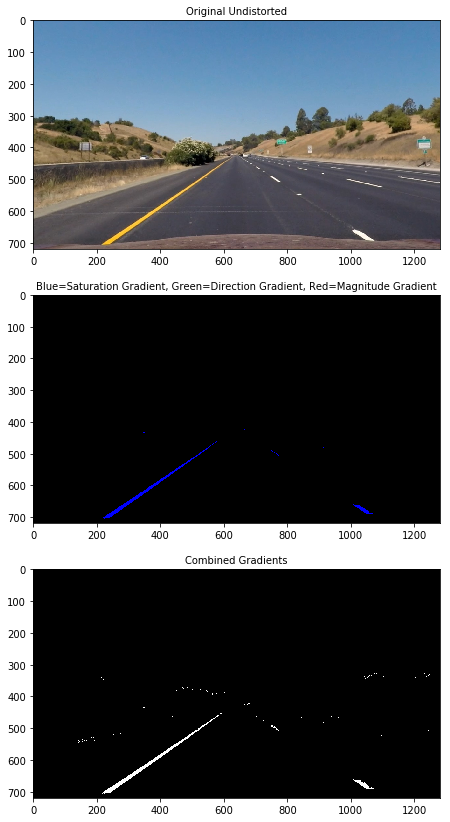

In [13]:
# interact creates the slides below. The three images below were used for testing purposes
interact(showGrad, img=fixed(test_road_images_undistorted[0]), 
    s_threshMin=widgets.IntSlider(value=150,min=0,max=255,step=1,description='MinS:',continuous_update=False,), 
    s_threshMax=widgets.IntSlider(value=255,min=0,max=255,step=1,description='MaxS:',continuous_update=False,), 
    sx_threshMin=widgets.IntSlider(value=90,min=0,max=255,step=1,description='MinSx:',continuous_update=False,), 
    sx_threshMax=widgets.IntSlider(value=200,min=0,max=255,step=1,description='MaxSx:',continuous_update=False,),
    sy_threshMin=widgets.IntSlider(value=90,min=0,max=255,step=1,description='MinSy:',continuous_update=False,),
    sy_threshMax=widgets.IntSlider(value=200,min=0,max=255,step=1,description='MaxSy:',continuous_update=False,),
    mag_threshMin=widgets.IntSlider(value=84,min=0,max=255,step=1,description='MinMag:',continuous_update=False,),
    mag_threshMax=widgets.IntSlider(value=54,min=0,max=255,step=1,description='MaxMag:',continuous_update=False,),
    dir_threshMin=widgets.FloatSlider(value=0.8,min=0,max=np.pi/2,step=0.05,description='MinDir:',continuous_update=False,),
    dir_threshMax=widgets.FloatSlider(value=0.6,min=0,max=np.pi/2,step=0.05,description='MaxDir:',continuous_update=False,),
    k_size=widgets.IntSlider(value=3,min=1,max=31,step=2,description='Ksize:',continuous_update=False,),
)

## 5. Convert all test road images into binary

In [14]:
test_road_images_binary = list(map(lambda x: pipeline(x)[1],test_road_images_undistorted))

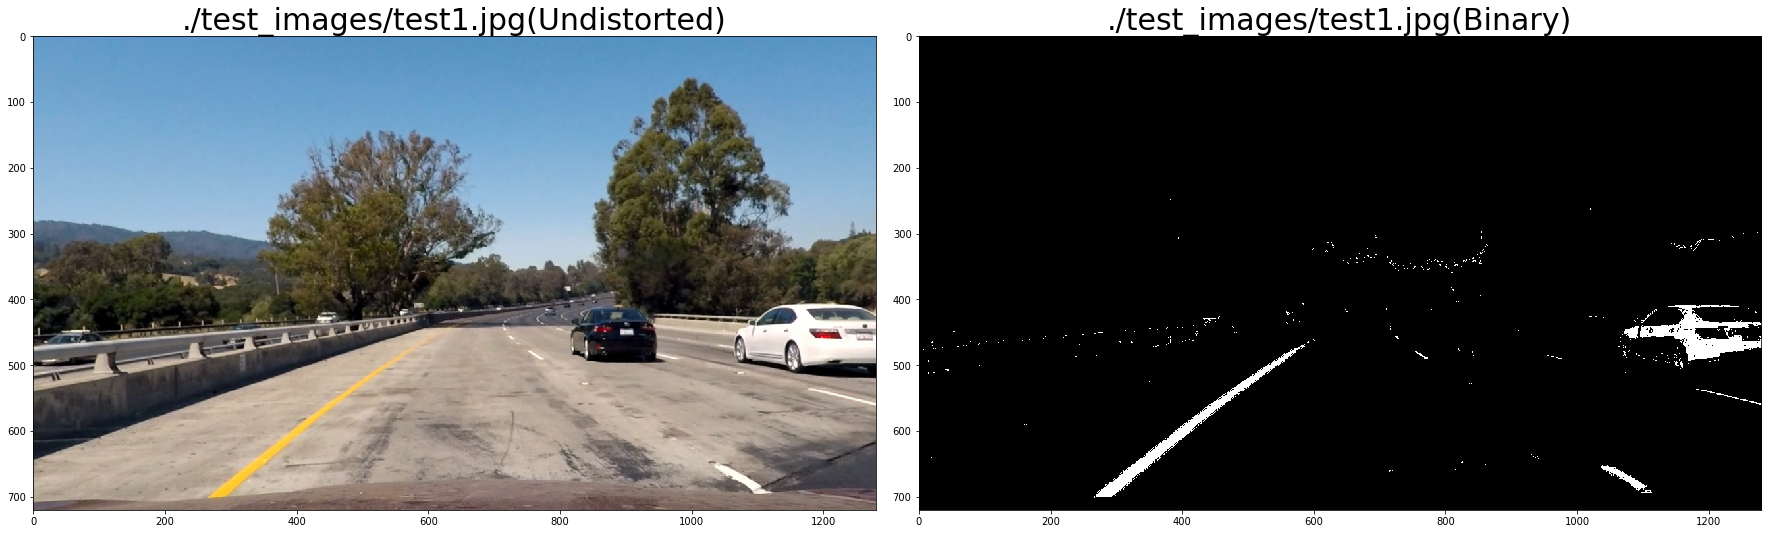

In [15]:
# The plots below show a side-by-side comparison of an original image and its binary threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(test_road_images_undistorted[2], cv2.COLOR_BGR2RGB))
ax1.set_title(test_road_image_filenames[2]+'(Undistorted)', fontsize=30)
ax2.imshow(test_road_images_binary[2], cmap='gray')
ax2.set_title(test_road_image_filenames[2]+'(Binary)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 6. Generate warp transformation functions

In [16]:
# This function is used to generate warp and inverse warp functions
def getWarpTransformers(image_to_warp,offsetX1=420,offsetY1=-230,offsetX2=-460,offsetY2=-230):
    x1 = 120
    y1 = image_to_warp.shape[0]-20
    x2 = image_to_warp.shape[1]-70
    y2 = image_to_warp.shape[0]-20
    
    src = np.float32([[x1, y1],[x2, y2],[x2+offsetX2, y2+offsetY2],[x1+offsetX1, y1+offsetY1]])
    dst = np.float32([[x1, y1],[x2, y2],[x2, y2-600],[x1, y1-600]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv, (x1,y1,x2,y2), (offsetX1,offsetY1,offsetX2,offsetY2)  

## 7. Test that the perspective transform works properly

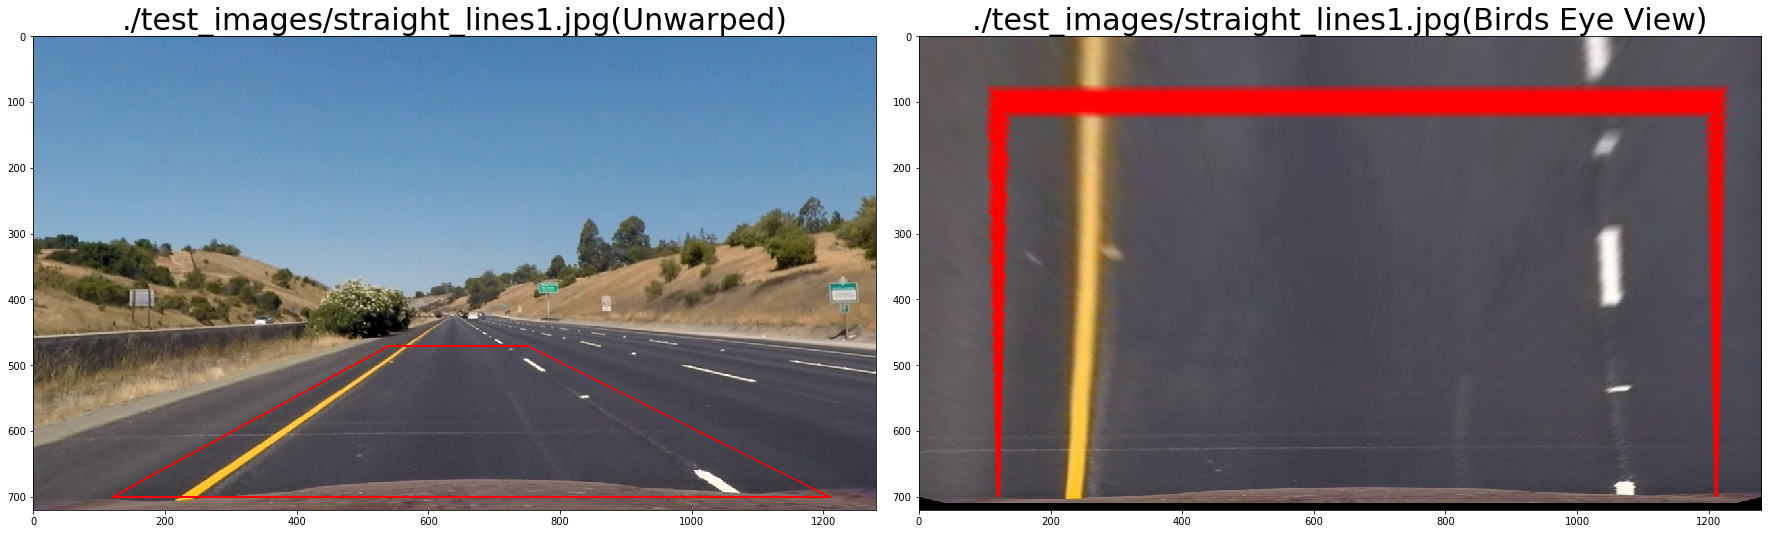

In [17]:
# Here we test the perspective transform on one of the Test images
test_image_to_warp = np.copy(test_road_images_undistorted[1])

M, Minv, base_coords, offsets = getWarpTransformers(test_image_to_warp)

test_image_to_warp = np.copy(test_road_images_undistorted[0])
color=[0, 0, 255]
thickness=2
cv2.line(test_image_to_warp, (base_coords[0], base_coords[1]), (base_coords[2], base_coords[3]), color, thickness)
cv2.line(test_image_to_warp, (base_coords[0]+offsets[0], base_coords[1]+offsets[1]), (base_coords[2]+offsets[2], base_coords[3]+offsets[3]), color, thickness)
cv2.line(test_image_to_warp, (base_coords[0], base_coords[1]), (base_coords[0]+offsets[0], base_coords[1]+offsets[1]), color, thickness)
cv2.line(test_image_to_warp, (base_coords[2], base_coords[3]), (base_coords[2]+offsets[2], base_coords[3]+offsets[3]), color, thickness)


image_to_warp_size = (test_image_to_warp.shape[1],test_image_to_warp.shape[0])
test_image_warped = cv2.warpPerspective(test_image_to_warp, M, image_to_warp_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(test_image_to_warp, cv2.COLOR_BGR2RGB))
ax1.set_title(test_road_image_filenames[0]+'(Unwarped)', fontsize=30)
ax2.imshow(cv2.cvtColor(test_image_warped, cv2.COLOR_BGR2RGB))
ax2.set_title(test_road_image_filenames[0]+'(Birds Eye View)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 8. Create function that generates lane overlay

In [18]:
# A line server is an objects that supports the funtion that detects the lane pixels and
# computes the line. It keeps a memory of the last left and right fits so as to speed up
# subsequent searches for line pixels

class LineServer():
    def __init__(self):
        self.last_left_fit = None
        self.last_right_fit = None
    def has_previous_fits(self):
        if(self.last_left_fit != None and self.last_right_fit != None):
            return True
        else:
            return False
    def set_line_fits(self,left,right):
        self.last_left_fit = left
        self.last_right_fit = right
    def get_line_fits(self):
        return self.last_left_fit,self.last_right_fit

        
line_server = None

In [31]:
# This function is a helper to identify lane pixels and compute a new line curve 
# This is used in the event that the line_server has no previous fits

def getLineFit(binary_warped_image):
    binary_warped = binary_warped_image

    # Taking a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
       
    return left_fit, right_fit,left_lane_inds,right_lane_inds

In [32]:
# This function takes in a binary image and outputs the colored in overlay of where it 
# predicts the lane to be

def getOverlay(input_img):   
    M, Minv,_,_ = getWarpTransformers(input_img)
    img_size = (input_img.shape[1],input_img.shape[0])
    binary_warped = cv2.warpPerspective(input_img, M, img_size, flags=cv2.INTER_LINEAR)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    midpoint = input_img.shape[1]/2 
    
    if(line_server!=None and line_server.has_previous_fits()):
        left_fit,right_fit = line_server.get_line_fits()
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        left_fit, right_fit,left_lane_inds,right_lane_inds = getLineFit(binary_warped)

    
    if(line_server!=None):
        line_server.set_line_fits(left_fit,right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size)
    
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1000 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    midpoint_meters = midpoint * xm_per_pix
    center_of_lane = ((right_fitx[-1] - left_fitx[-1])/2) + left_fitx[-1]
    off_from_center = round(center_of_lane*xm_per_pix - midpoint_meters,2)
    off_from_center_abs = abs(off_from_center)
    
    if(off_from_center == off_from_center_abs):
        offset_direction = "left"
    else:
        offset_direction = "right"
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(newwarp,'Left Curve = '+str(int(left_curverad))+' m',(10,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(newwarp,'Right Curve = '+str(int(right_curverad))+' m',(10,120), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(newwarp,'Center offset = '+str(off_from_center_abs)+' m '+offset_direction+" of center",(10,160), font, 1,(255,255,255),2,cv2.LINE_AA)
    return newwarp,(out_img,left_fitx,right_fitx,ploty)

## 9. Test that the overlay generation works properly

/home/vagrant/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


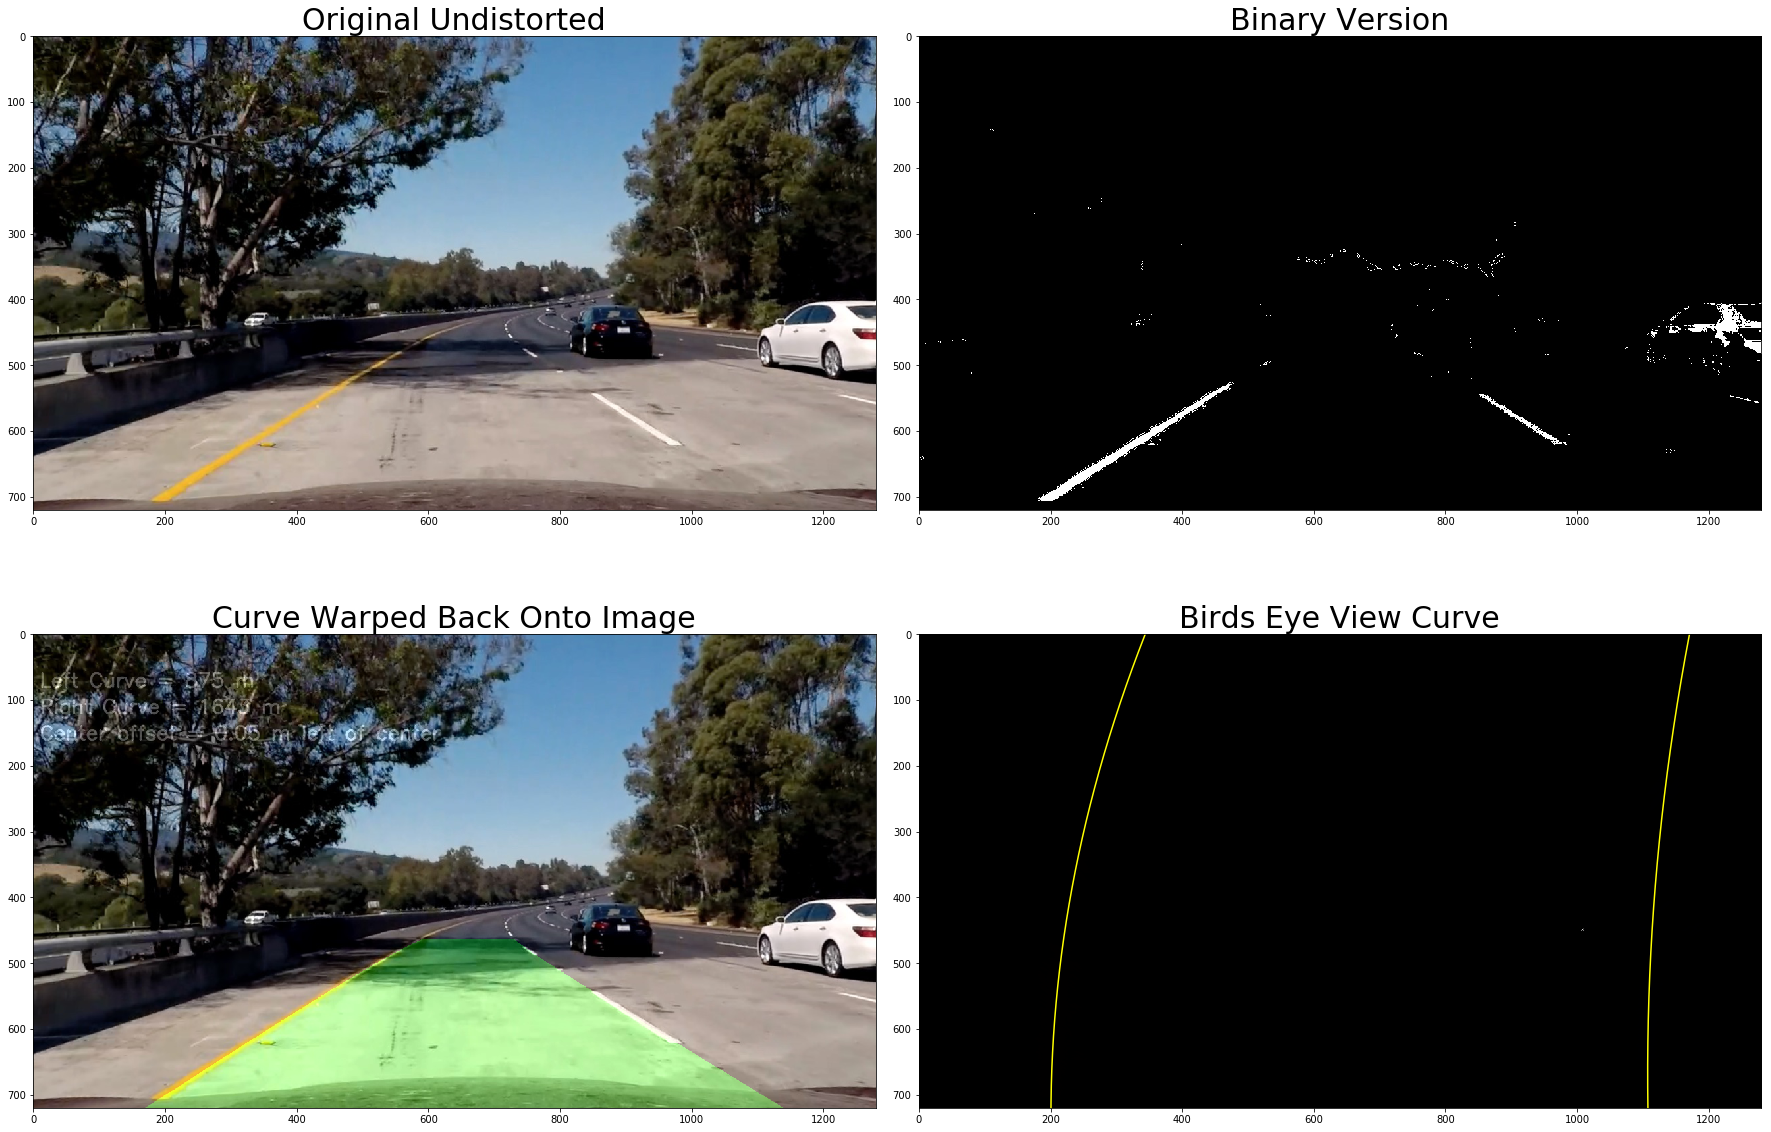

In [33]:
# Here we take an test image to demonstrate that the getOverlay function works

test_image_for_overlay = np.copy(test_road_images_undistorted[6])
test_image_for_overlay_binary = pipeline(test_image_for_overlay)[1]

view1,view2 = getOverlay(test_image_for_overlay_binary)

view1 = cv2.addWeighted(test_image_for_overlay, 1, view1, 0.3, 0)
f, axes = plt.subplots(2, 2, figsize=(24, 18))
f.tight_layout()
axes[0,0].imshow(cv2.cvtColor(test_image_for_overlay, cv2.COLOR_BGR2RGB))
axes[0,0].set_title('Original Undistorted', fontsize=30)
axes[0,1].imshow(test_image_for_overlay_binary,cmap='gray')
axes[0,1].set_title('Binary Version', fontsize=30)
axes[1,0].imshow(cv2.cvtColor(view1, cv2.COLOR_BGR2RGB))
axes[1,0].set_title('Curve Warped Back Onto Image', fontsize=30)


axes[1,1].imshow(view2[0])
axes[1,1].set_title('Birds Eye View Curve', fontsize=30)
axes[1,1].plot(view2[1], view2[3], color='yellow')
axes[1,1].plot(view2[2], view2[3], color='yellow')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 10. Create a function that stitches together the entire image processing pipeline 

In [ ]:
# This function pieces together the individual functions above into an end-to-end pipeline for
# processing the video images

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    global line_server
    
    if(line_server == None):
        line_server = LineServer()
    result = undist(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
#     M,_,_,_ = getWarpTransformers(result)
#     img_size = (result.shape[1],result.shape[0])
    result = pipeline(result)[1]
    result = getOverlay(result)[0]
    result = cv2.addWeighted(image, 1, result, 0.3, 0)
    return result


In [ ]:
# importing the libraries needed for the video processing
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# processing the project video

test_video1 = './my_output/my_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
test_video1_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_video1_clip.write_videofile(test_video1, audio=False)

In [ ]:
# displaying the video processing results
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video1))